In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from sklearn.datasets import make_swiss_roll

from theano import function

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.sandbox.regularization import ITLRegularizer
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot

batch_size = 100
nb_epoch = 100
code_size = 2

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 7
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32").reshape((-1, 784))
X_test = X_test.astype("float32").reshape((-1, 784))
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

Using Theano backend.
X_train shape: (60000, 784)
60000 train samples
10000 test samples


Using gpu device 0: GeForce GTX 680 (CNMeM is disabled)


In [2]:
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
rng = RandomStreams()

def swiss_roll(size, noise=.1, rng=rng):
    # inspired by sklearn code
    u = rng.uniform(size=(size[0], 1))
    t = 1.5 * np.pi * (1 + 2 * u)
    x = t * T.cos(t)
    # y = 21 * u2
    z = t * T.sin(t)

    X = K.concatenate([x, z], axis=-1)
    X += noise * rng.uniform(size=(size[0], 2))
    return X


"\nfrom theano import as_op\nimport theano\ndef infer_shape_numpy_dot(node, input_shapes):\n    print(node)\n    return node\n\n@as_op(itypes=[theano.tensor.TensorType('float32', 'vector')],\n       otypes=[theano.tensor.dmatrix], infer_shape=infer_shape_numpy_dot)\ndef laplace(shape):\n    return np.random.laplace(shape.astype('int')).astype('float32')\n"

In [3]:
enc = Sequential()
enc.add(Dense(1000, input_dim=784, activation='tanh'))
enc.add(BN())
enc.add(Dense(1000, activation='tanh'))
enc.add(BN())
enc.add(Dense(code_size))
enc.add(ITLRegularizer(distance='euclidean', scale=30., ksize=6.,
                       distribution=swiss_roll
                      ))

In [4]:
dec = Sequential()
dec.add(Dense(1000, input_dim=code_size, activation='relu'))
dec.add(Dense(784, activation='sigmoid'))

In [5]:
model = Sequential()
model.add(enc)
model.add(dec)

model.compile(loss='mse', optimizer='adam')

In [ ]:
    #cbk = ModelCheckpoint('itl.hdf5', save_best_only=True, verbose=True)

    #try:
    model.fit(X_train, X_train.reshape((-1, 784)), batch_size=batch_size, nb_epoch=nb_epoch, verbose=2,
          validation_data=(X_valid, X_valid.reshape((-1, 784))),
          #callbacks=[cbk]
         )
    #except:
    #pass

# Load best model

In [7]:
#model.load_weights('itl.hdf5')

# Sample (for visualization purposes)

In [8]:
X = K.placeholder(ndim=2)
Y = dec(X)
F = function([X], Y, allow_input_downcast=True)

(100, 2)


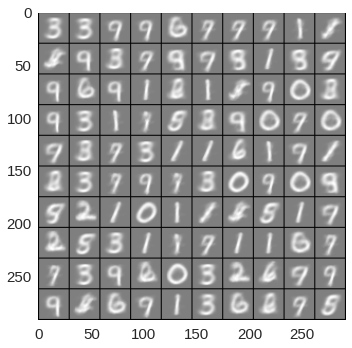

In [9]:
x = make_swiss_roll(100, noise=.1)[0]; x = x[:, [0, 2]]
print(x.shape)
y = F(x)
I = grid2d(y.reshape((100, -1)))
plt.imshow(I, cmap='gray')

# Visualize projection

In [10]:
X = K.placeholder(ndim=2)
Y = enc(X)
G = function([X], Y, allow_input_downcast=True)

In [11]:
y = G(X_train[:6000])

/home/eders/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/eders/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


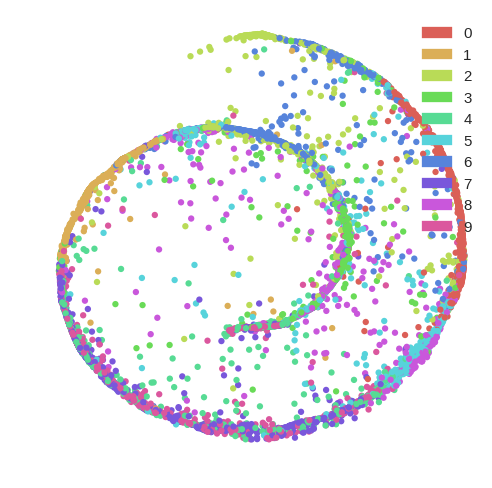

In [12]:
_ = embedding2dplot(y, y_train[:6000], show_median=False)
plt.legend()